<a href="https://colab.research.google.com/github/mgite03/bu-ai4all-2019/blob/main/rl/Copy_of_Deep_RL_implemented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep RL

# Building a model

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import tqdm
from time import time
import pickle

In [ ]:
class Q(nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        self.layer1 = nn.Linear(4,100)
        self.layer2 = nn.Linear(100,400)
        self.layer3 = nn.Linear(400,200)
        self.layer4 = nn.Linear(200,50)
        self.layer5 = nn.Linear(50,2)
        self.leakyrelu = nn.LeakyReLU()
    def forward(self, x):
        x = self.leakyrelu(self.layer1(x))
        x = self.leakyrelu(self.layer2(x))
        x = self.leakyrelu(self.layer3(x))
        x = self.leakyrelu(self.layer4(x))
        x = self.layer5(x)
        return x 

# Gain Experience

In [ ]:
def get_new_experience(q, env, num_transitions, epsilon):
    # returns experience array: (state(4), action(1), new state(4), reward(1), done(1))
    
    # create an empty array that we will fill with transitions
    transitions = torch.full((num_transitions, 10), np.nan)
    
    # reset environment
    s = env.reset()
    
    s = torch.from_numpy(s).float() # make s into a torch tensor
    
    done = False
    for i in range(num_transitions):
      
        # if the episode is done, reset the environment
        if done:
            s = env.reset()
            s = torch.Tensor(s) # make s into a torch tensor
            
        # choose exploration or exploitation
        rand = random.random()
        if rand > epsilon or rand > 0.1:
            a = torch.argmax(q(s))
        else:
            a = torch.Tensor([random.randint(0,1)]).int().squeeze()

        # take action a    
        s_new, r, done, _ = env.step(a.numpy())

        s_new = torch.from_numpy(s_new).float() # make s_new into a torch tensor
        r = torch.Tensor([r]) # make r into a torch tensor

        # store the transition in the transitions tensor
        transitions[i,:4] = s
        transitions[i,4:5] = a
        transitions[i,5:9] = s_new
        transitions[i,9:10] = r

        s = s_new
        
    return transitions

# Define training function

In [ ]:
def train(q, gamma, criterion, optimizer, num_epochs, num_transitions, buffer_size):
  
    # set up some bookkeeping
    keep_track_of_loss = []
    running_loss = 0
    episode_lengths = np.zeros(num_epochs)
    
    # initialize epsilon
    epsilon = 0.9
    
    # initialize experience
    experience = get_new_experience(q, env, buffer_size, epsilon) # DEVICE

    for epch in tqdm.tqdm(range(num_epochs)):
        experience = torch.cat((experience[num_transitions:], 
                                get_new_experience(q, env, num_transitions, epsilon)), 
                               dim=0)

        # extract values from experience tensor
        s = experience[:,:4]
        a = experience[:,4]
        s_new = experience[:,5:9]
        r = experience[:,9].view(-1,1) # fix r's dimensions
        
        
        # implement Bellman equation
        
        # calculate q(s,a)
        y = q(experience[:,:4])
        the_actions_taken = a.view(1,-1).long()
        indicies = torch.arange(buffer_size, dtype=torch.float32).unsqueeze(dim=0).long()
        q_predicted = y[(indicies, the_actions_taken)].view(-1,1)

        # calculate r + gamma * q(s', a')
        q_max_values = torch.max(q(s_new), dim=1).values.unsqueeze(dim=1) 
        q_desired = r + gamma*q_max_values
        
        
        # update q

        # calculate loss
        loss = criterion(q_predicted, q_desired)
        # reset the gradients
        optimizer.zero_grad()
        # calculate the gradients
        loss.backward()
        # update the weights
        optimizer.step()

        
        # check episode length
        step_counter= 0
        for _ in range(3):
            s = env.reset()
            s = torch.Tensor(s)
            done= False
            while not done:
                a = torch.argmax(q(s))
                s_new, r, done, _ = env.step(a.numpy())
                s = torch.Tensor(s_new)
                step_counter += 1
        episode_lengths[epch] = step_counter/3.

        # keep track of the loss
        running_loss += loss/buffer_size
        if epch%10==9:
            keep_track_of_loss.append(running_loss/10.)
            running_loss=0

        # update epsilon
        epsilon *= 0.999
    
    # return the episode lengths so we can see how the model progressed, and also the losses so we can plot them
    return episode_lengths, keep_track_of_loss

# Train

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
q = Q()
criterion = nn.MSELoss()
optimizer = optim.Adam(q.parameters(), lr=0.01)

gamma = 0.99
num_epochs = 1000
num_transitions = 1000
buffer_size = 5000

episode_lengths, all_losses = train(q, gamma, criterion, optimizer, num_epochs, num_transitions, buffer_size)

100%|██████████| 1000/1000 [08:02<00:00,  2.10it/s]


In [ ]:
list_of_episode_lengths = []
list_of_all_losses = []
list_of_models = []

for _ in range(10):
  q = Q()
  criterion = nn.MSELoss()
  optimizer = optim.Adam(q.parameters(), lr=0.01)
  episode_lengths, all_losses = train(q, gamma, criterion, optimizer, num_epochs, num_transitions, buffer_size)
  
  list_of_episode_lengths.append(episode_lengths)
  list_of_all_losses.append(all_losses)
  list_of_models.append(q)

100%|██████████| 1000/1000 [08:23<00:00,  2.08it/s]


# Examine the results

Define some useful functions to look at our episode lengths and loss curve:

In [ ]:
def plot_loss_curve(all_losses):
  plt.plot([10*e for e in range(len(all_losses))], all_losses)
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Loss Curve")
  plt.show()

def plot_episode_lengths(episode_lengths):
  plt.scatter(range(len(episode_lengths)), episode_lengths, marker=".")
  plt.xlabel("epoch")
  plt.ylabel("episode length")
  plt.title("Model Performance: Episode Lengths")
  plt.show()

Plot the performace of the models that you've trained. See if you have trained a good one.

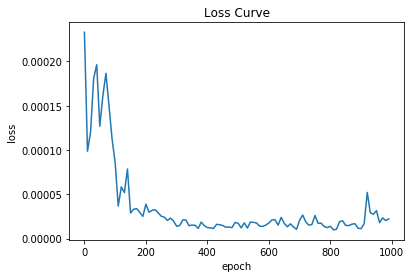

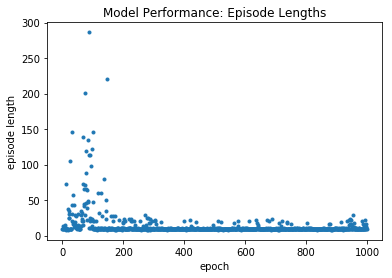

In [ ]:
plot_loss_curve(all_losses)
plot_episode_lengths(episode_lengths)

Model 1


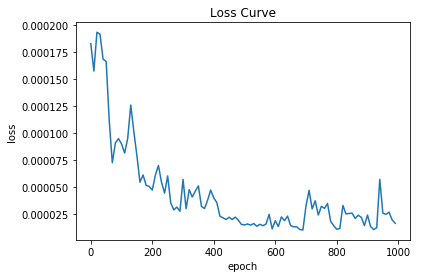

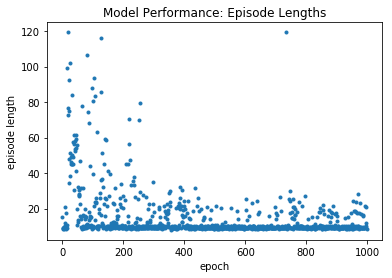

Model 2


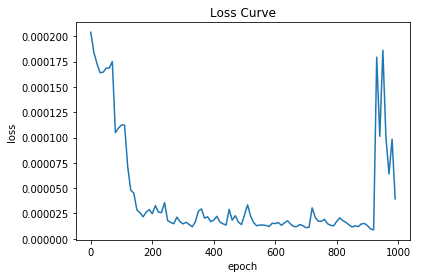

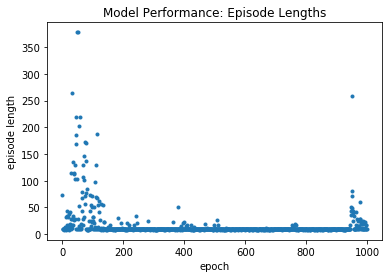

Model 3


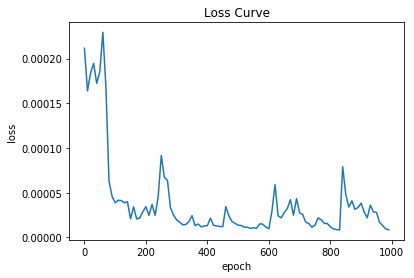

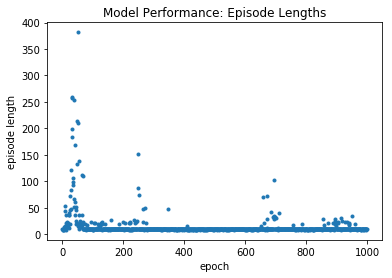

Model 4


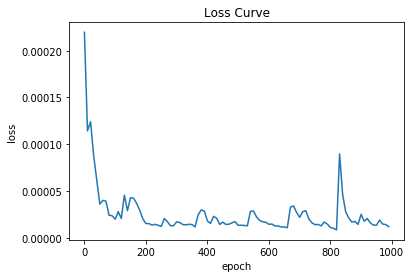

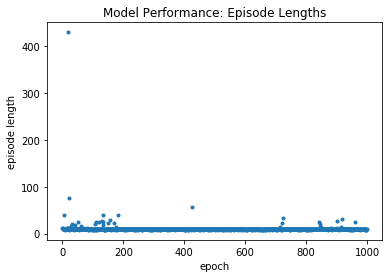

Model 5


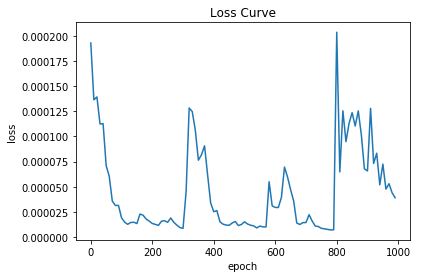

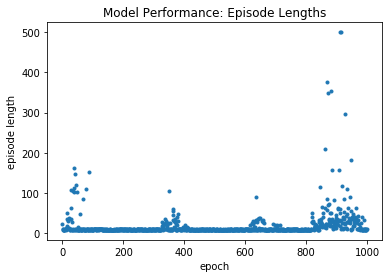

Model 6


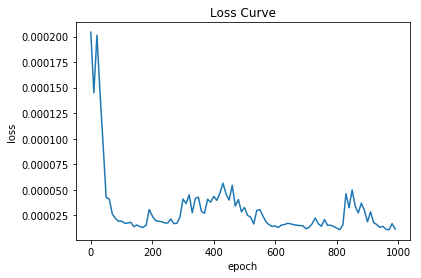

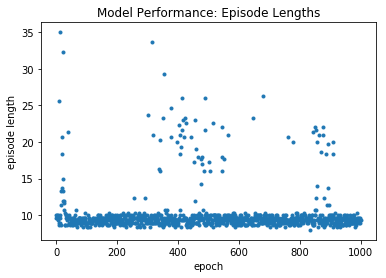

Model 7


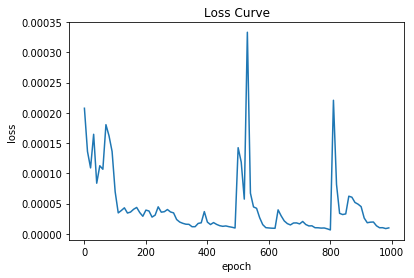

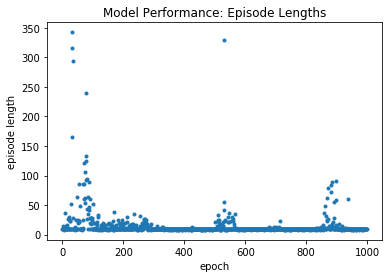

Model 8


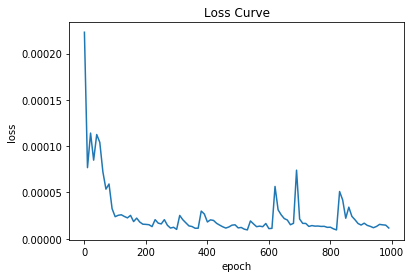

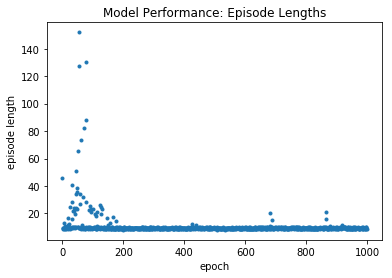

Model 9


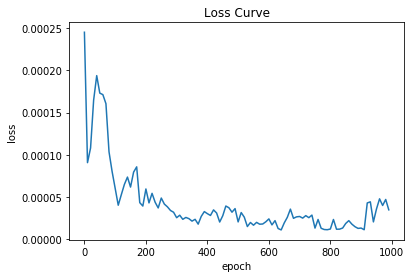

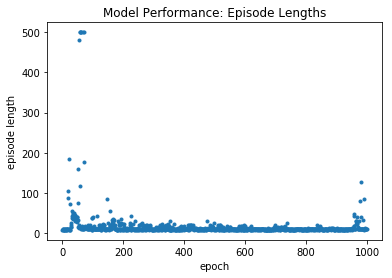

Model 10


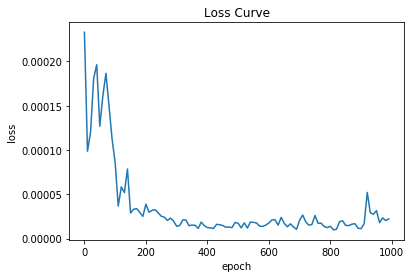

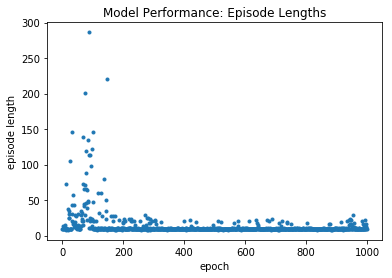

In [ ]:
for i in range(10):
  print("Model {}".format(i+1))
  plot_loss_curve(list_of_all_losses[i])
  plot_episode_lengths(list_of_episode_lengths[i])